## Average Vote vs. Metascore
#### Hypothesis:
As the avg vote increases, so will the metascore.

In [49]:
imdb_movies_clean <- imdb_movies %>%
    na.omit(imdb_movies)

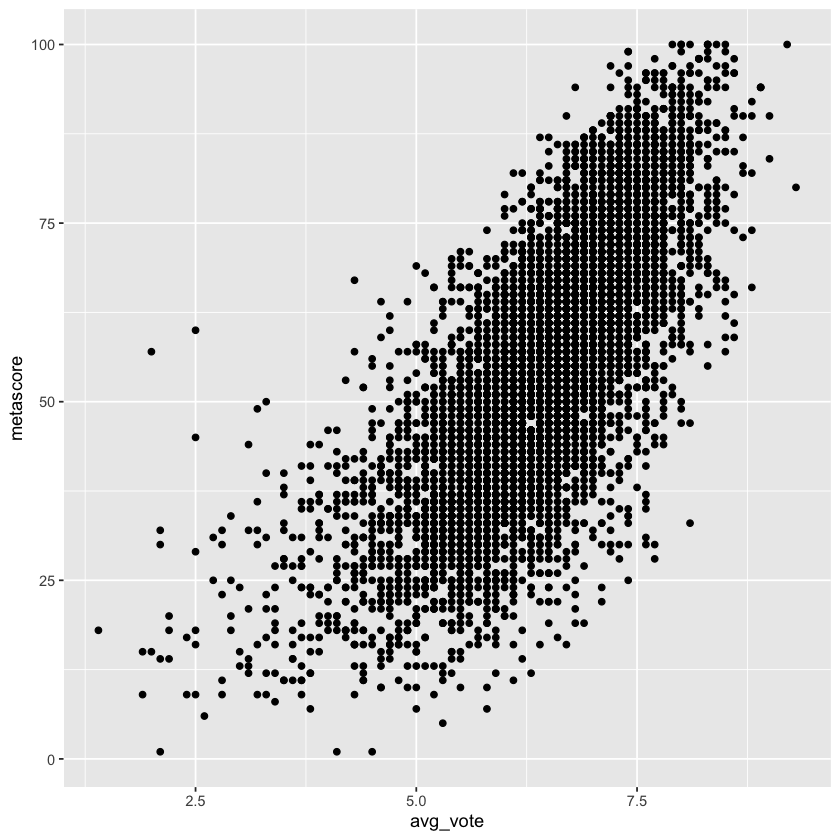

In [50]:
ggplot(data = imdb_movies_clean) +
    geom_point(aes(x = avg_vote, y = metascore))

In [51]:
# training set is random 60% of total dataset
train1 <- imdb_movies_clean %>%
    sample_frac(0.60)

In [52]:
# this is the 40% split that will be divided into the 20%/20% validation and test sets
# intermediate step to get validation and test set
valid_test1 <- anti_join(imdb_movies_clean, train1, by = "imdb_title_id")

# validation set is 20% split of data 
valid1 <- valid_test1 %>%
    sample_frac(0.50)

# test set is last 20% of data
test1 <- anti_join(valid_test1, valid1, by = "imdb_title_id")

In [53]:
RMSE_vm <- function(a, data) {
    preds <- a[1] + data$x * a[2]
    diffs <- data$y - preds
    sqrt(mean(diffs^2))
}

best_lin2 <- optim(c(0, 0), RMSE_vm,  data = mutate(train1, x = avg_vote, y = metascore))
best_lin2$par

a_lin_vm <- best_lin2$par

[1] -32.31964  13.54240

In [54]:
# again line still overfitted to training set
RMSE_vm(a_lin_vm, data = mutate(valid1, x = avg_vote, y = metascore))

RMSE_vm(a_lin_vm, data = mutate(test1, x = avg_vote, y = metascore))

[1] 12.45094

[1] 12.45682

In [55]:
# next up is a binary classification model
# create a binary TRUE/FALSE column
train2 <- train1 %>%
    mutate(metascore_above50 = metascore > 50)

cols <- sapply(train2, is.logical)
train2[, cols] <- lapply(train2[, cols], as.double)

# reference for code:
# https://stackoverflow.com/questions/30943167/replace-logical-values-true-false-with-numeric-1-0

In [56]:
logistic_model_vm <- function(a, data) {
    (1) / (1 + exp(-(a[1] + data$x * a[2])))
}

In [57]:
BCE_vm <- function(a, data) {
    preds <- logistic_model_vm(a, data) #finds p(xi)
    truth <- data$y #finds yi, either 0 or 1
    value <- truth * log(preds) + (1 - truth) * log(1 - preds)
    mean(-value)
}

best_log_vm <- optim(c(0, 0), BCE_vm, data = mutate(train2, x = avg_vote, y = metascore_above50))
best_log_vm

a_log_vm <- best_log_vm$par

$par
[1] -13.438055   2.159245

$value
[1] 0.4447587

$counts
function gradient 
      85       NA 

$convergence
[1] 0

$message
NULL

In [58]:
# need to observe accuracy of logistic model
avg_accuracy_log_vm <- function(a, data, threshold = 0.5) {
    preds <- logistic_model_vm(a, data)   # get predictions for our data
    preds <-  preds > 0.5   # turn our probabilities into predictions, using our threshold
        #this takes predicition, and turns into a boolean, true or false, anything > 0.5 is true, < 0.5 is false
    
    # remember that in a Boolean vector, T is 1 and F is 0!
    truth <- data$y
    wrong <- abs(preds - truth)
    pct_wrong <- sum(wrong) / length(wrong)
    1 - pct_wrong
}

In [59]:
# avg_accuracy score of training set
avg_accuracy_log_vm(a_log_vm, mutate(train2, x = avg_vote, y = metascore_above50))


[1] 0.7876574

In [60]:
# create a binary TRUE/FALSE column for validation set
valid2 <- valid1 %>%
    mutate(metascore_above50 = metascore > 50)

cols <- sapply(valid2, is.logical)
valid2[, cols] <- lapply(valid2[, cols], as.double)

# new test set with binary TRUE/FALSE column
test2 <- test1 %>%
    mutate(metascore_above50 = metascore > 50)

cols <- sapply(test2, is.logical)
test2[, cols] <- lapply(test2[, cols], as.double)


In [61]:
# avg_accuracy score of validation set
avg_accuracy_log_vm(a_log_vm, mutate(valid2, x = avg_vote, y = metascore_above50))

# avg_accuracy score of test set
avg_accuracy_log_vm(a_log_vm, mutate(test2, x = avg_vote, y = metascore_above50))

[1] 0.7928949

[1] 0.7634165

In [62]:
# check accuracy of linear regression model
avg_accuracy_lin_vm <- function(a, data, threshold = 0.5) {
    preds <- RMSE_vm(a, data)   # get predictions for our data
    preds <-  preds > 0.5   # turn our probabilities into predictions, using our threshold
        #this takes predicition, and turns into a boolean, true or false, anything > 0.5 is true, < 0.5 is false
    
    # remember that in a Boolean vector, T is 1 and F is 0!
    truth <- data$y
    wrong <- abs(preds - truth)
    pct_wrong <- sum(wrong) / length(wrong)
    1 - pct_wrong
}

In [63]:
# accuracy of linear regression model on training set
# accuracy was much worse than binary classification, line overfitted
avg_accuracy_lin_vm(a_lin_vm, mutate(train2, x = avg_vote, y = metascore_above50))

[1] 0.5904282

In [64]:
# accuracy of linear regression model on validation set
# accuracy was much worse than binary classification, line overfitted
avg_accuracy_lin_vm(a_lin_vm, mutate(valid2, x = avg_vote, y = metascore_above50))

[1] 0.6031746

In [65]:
# accuracy of linear regression model on test set
# accuracy was much worse than binary classification, line overfitted
avg_accuracy_lin_vm(a_lin_vm, mutate(test2, x = avg_vote, y = metascore_above50))

[1] 0.5895692

We found that there was indeed a positive relationship between avg_vote and metascore. This makes sense because if the audience gave a movie a high score, then it stands to reason that the metascore from the critics would be high as well.  

Furthermore, the binary classification model again outperforms the linear regression model.